# A little introduction to autoencoder

An autoencoder is a type of artificial neural network used for unsupervised learning, aiming to find efficient representations of unlabeled data. It achieves this through two main functions:

- **Encoding Function**: Transforms input data to an encoded, often lower-dimensional, representation.
- **Decoding Function**: Reconstructs the original input data from the encoded representation.

Autoencoders are commonly applied for tasks such as dimensionality reduction, anomaly detection, facial recognition, and generative modeling, where they generate new data resembling the original inputs.

## Mathematical Principles

### Definition

An autoencoder is defined by the following components:

1. **Spaces**:  
   - The decoded message space $ \mathcal{X} $ and the encoded message space $ \mathcal{Z} $.
   - Typically, $ \mathcal{X} = \mathbb{R}^m $ and $ \mathcal{Z} = \mathbb{R}^n $ with $ m > n $.

2. **Parametrized Function Families**:  
   - Encoder function $ E_{\phi}: \mathcal{X} \rightarrow \mathcal{Z} $, parametrized by $ \phi $.
   - Decoder function $ D_{\theta}: \mathcal{Z} \rightarrow \mathcal{X} $, parametrized by $ \theta $.

   For any input $ x \in \mathcal{X} $, the encoder produces a code $ z = E_{\phi}(x) $, which we refer to as the latent variable or latent representation. Conversely, for any encoded message $ z \in \mathcal{Z} $, the decoder reconstructs the message $ x' = D_{\theta}(z) $.

3. **Encoder Model**:
   - For example, a one-layer encoder may be represented by:
     $$
     E_{\phi}(x) = \sigma(Wx + b)
     $$
     where $ \sigma $ is an activation function, $ W $ a weight matrix, and $ b $ a bias vector.

### Training an Autoencoder

An autoencoder minimizes reconstruction loss based on a defined task. Given a probability distribution $ \mu_{\text{ref}} $ over $ \mathcal{X} $ and a reconstruction quality function $ d: \mathcal{X} \times \mathcal{X} \rightarrow [0, \infty] $ measuring the difference between $ x $ and its reconstruction $ x' $, we define the loss function as:
$$
L(\theta, \phi) := \mathbb{E}_{x \sim \mu_{\text{ref}}}[d(x, D_{\theta}(E_{\phi}(x)))]
$$
The objective is to find parameters $ \theta $ and $ \phi $ that minimize this loss:
$$
\arg \min_{\theta, \phi} L(\theta, \phi)
$$

In practice, if $ \mu_{\text{ref}} $ represents a dataset $ \{x_1, \dots, x_N\} \subset \mathcal{X} $, then the loss function can be simplified to the mean squared error:
$$
L(\theta, \phi) = \frac{1}{N} \sum_{i=1}^{N} \|x_i - D_{\theta}(E_{\phi}(x_i))\|_2^2
$$
where $ \| \cdot \|_2 $ is the Euclidean norm.

### Optimization

Autoencoders are typically trained via gradient descent, optimizing the parameters $ \theta $ and $ \phi $ to minimize the reconstruction error.

## Interpretation

An autoencoder has two primary components:
- **Encoder**: Maps the input $ x $ to a lower-dimensional representation $ z $.
- **Decoder**: Reconstructs $ x $ from $ z $, ideally with minimal information loss.

If the dimensionality of $ \mathcal{Z} $ (the encoded space) is smaller than $ \mathcal{X} $ (the input space), the autoencoder is termed **undercomplete** and acts as a form of data compression. At its ideal setting, each code $ z $ in $ \mathcal{Z} $ represents a realistic input $ x $ from the distribution $ \mu_{\text{ref}} $, allowing the decoder to generate realistic data points by decoding arbitrary $ z $ values.

However, if $ \mathcal{Z} $ has the same or larger dimension than $ \mathcal{X} $, the autoencoder risks learning an identity function, which would make it uninformative. To avoid this, various regularization techniques and modifications, such as sparse or denoising autoencoders, are applied to encourage the autoencoder to capture meaningful patterns in the data.

## Now, let’s start building a very simple autoencoder

We'll use PyTorch to train our autoencoder model on the MNIST dataset.

### Import dependencies

In [34]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler, Sampler
import numpy as np
from matplotlib.lines import Line2D
import random

# If GPU is available :
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


### Hyperparameters

In [2]:
learning_rate = 0.0005
batch_size = 256
num_epochs = 30
num_classes = 10

### Ensure reproductibility

In [3]:
seed = 42
torch.manual_seed(seed)  # Ensure reproducibility for all operations in PyTorch on the CPU
torch.cuda.manual_seed_all(seed)  # Ensure reproducibility for all operations in PyTorch on the GPU
random.seed(seed)  # Ensure reproducibility for all operations using Python's random module

### Data loader for MNIST dataset

In [4]:
def get_dataloaders(batch_size, num_workers=0, train_transforms=None, test_transforms=None):
    # Apply basic transforms if none are provided; converts images to tensors by default
    if train_transforms is None:
        train_transforms = transforms.ToTensor()
    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    # Define training and validation datasets with applied transformations
    train_dataset = datasets.MNIST(root='data', train=True, transform=train_transforms, download=True)
    valid_dataset = datasets.MNIST(root='data', train=False, transform=test_transforms)

    # Data loaders with shuffle for train (randomizes order) and no shuffle for validation
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    return train_loader, valid_loader

In [5]:
train_loader, valid_loader = get_dataloaders(batch_size=batch_size,
    num_workers=2)

In [6]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([1, 2, 8, 5, 2, 6, 9, 9, 9, 4])


### Define the AutoEncoder Model

In [7]:
class Trim(nn.Module):
    # Custom layer to trim the output to (1, 28, 28) dimensions, if needed
    def forward(self, x):
        return x[:, :, :28, :28]

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder network: progressively reduces image dimensions to a compact latent space
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 1 input channel to 32, retains 28x28
            nn.LeakyReLU(0.01),  # Leaky ReLU activation with small negative slope
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32 to 64 channels, reduces to 14x14
            nn.LeakyReLU(0.01),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # Reduces to 7x7
            nn.LeakyReLU(0.01),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # Keeps 7x7 but further processes
            nn.LeakyReLU(0.01),
            
            nn.Flatten(),  # Flattens output to (batch_size, 3136)
            nn.Linear(3136, 2)  # Reduces to 2-dimension for compact latent representation
        )
        
        # Decoder network: reconstructs image from the compact latent representation
        self.decoder = nn.Sequential(
            nn.Linear(2, 3136),  # Expands 2-dimensional latent to 3136
            nn.Unflatten(1, (64, 7, 7)),  # Reshapes to (batch_size, 64, 7, 7)
            
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),  # Keeps 7x7
            nn.LeakyReLU(0.01),
            
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),  # Expands to 14x14
            nn.LeakyReLU(0.01),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),  # Expands to 28x28
            nn.LeakyReLU(0.01),
            
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=0),  # Reduces channels back to 1
            Trim(),  # Adjusts output size to match original (1, 28, 28)
            
            nn.Sigmoid()  # Sigmoid activation to constrain output to [0, 1] range
        )

    def forward(self, x):
        x = self.encoder(x)  # Pass input through encoder
        x = self.decoder(x)  # Pass encoded data through decoder to reconstruct image
        return x

### Create the trainer 

In [8]:
# Initialize AutoEncoder model and Adam optimizer with defined learning rate
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Computes average loss for each epoch over entire dataset
def compute_epoch_loss(model, data_loader, device, loss_fn):
    total_loss = 0
    total_batches = 0
    for features, _ in data_loader:
        features = features.to(device)
        logits = model(features)  # Reconstructed image
        loss = loss_fn(logits, features)  # Compute reconstruction loss
        total_loss += loss.item()
        total_batches += 1
    return total_loss / total_batches

# Main training function with logging and model saving
def train(num_epochs, model, optimizer, train_loader, loss_fn=None, logging_interval=100, skip_epoch_stats=False, save_model=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    log_dict = {'train_loss_per_batch': [], 'train_loss_per_epoch': []}

    # Default to MSE loss if no specific loss function is provided
    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        for batch_idx, (features, _) in enumerate(train_loader):
            features = features.to(device)  # Move data to GPU if available
            
            logits = model(features)  # Forward pass
            loss = loss_fn(logits, features)  # Compute loss against original input
            optimizer.zero_grad()
            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters
            
            # Log batch loss
            log_dict['train_loss_per_batch'].append(loss.item())
            
            # Display batch loss if logging_interval is reached
            if batch_idx % logging_interval == 0:
                print(f'Epoch: {epoch + 1}/{num_epochs} | Batch {batch_idx + 1}/{len(train_loader)} | Loss: {loss:.4f}')
        
        # Compute average loss for the epoch if required
        if not skip_epoch_stats:
            model.eval()
            with torch.no_grad():
                train_loss = compute_epoch_loss(model, train_loader, device, loss_fn)
                print(f'***Epoch: {epoch + 1}/{num_epochs} | Avg Epoch Loss: {train_loss:.3f}')
            log_dict['train_loss_per_epoch'].append(train_loss)

    end_time = time.time()
    print(f'Total Training Time: {(end_time - start_time) / 60:.2f} min')

    # Save model to file if a path is specified
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
        
    return model, log_dict  # Return trained model and log dictionary

### Training the model 

In [9]:
model, log_dict = train(num_epochs=num_epochs, model=model,
                                optimizer=optimizer,
                                train_loader=train_loader,
                                skip_epoch_stats=False,
                                logging_interval=250)

Epoch: 1/30 | Batch 1/235 | Loss: 0.2086
***Epoch: 1/30 | Avg Epoch Loss: 0.054
Epoch: 2/30 | Batch 1/235 | Loss: 0.0550
***Epoch: 2/30 | Avg Epoch Loss: 0.050
Epoch: 3/30 | Batch 1/235 | Loss: 0.0498
***Epoch: 3/30 | Avg Epoch Loss: 0.047
Epoch: 4/30 | Batch 1/235 | Loss: 0.0467
***Epoch: 4/30 | Avg Epoch Loss: 0.045
Epoch: 5/30 | Batch 1/235 | Loss: 0.0445
***Epoch: 5/30 | Avg Epoch Loss: 0.044
Epoch: 6/30 | Batch 1/235 | Loss: 0.0432
***Epoch: 6/30 | Avg Epoch Loss: 0.043
Epoch: 7/30 | Batch 1/235 | Loss: 0.0434
***Epoch: 7/30 | Avg Epoch Loss: 0.042
Epoch: 8/30 | Batch 1/235 | Loss: 0.0447
***Epoch: 8/30 | Avg Epoch Loss: 0.042
Epoch: 9/30 | Batch 1/235 | Loss: 0.0412
***Epoch: 9/30 | Avg Epoch Loss: 0.041
Epoch: 10/30 | Batch 1/235 | Loss: 0.0434
***Epoch: 10/30 | Avg Epoch Loss: 0.041
Epoch: 11/30 | Batch 1/235 | Loss: 0.0413
***Epoch: 11/30 | Avg Epoch Loss: 0.040
Epoch: 12/30 | Batch 1/235 | Loss: 0.0407
***Epoch: 12/30 | Avg Epoch Loss: 0.040
Epoch: 13/30 | Batch 1/235 | Loss:

### Plotting the training loss against iterations 

In [10]:
def plot_training_logs(log_dict):
    """
    Plots the mini-batch loss and running average epoch loss on the same graph
    """
    # Extract losses from the log dictionary
    batch_losses = log_dict.get('train_loss_per_batch', [])
    epoch_losses = log_dict.get('train_loss_per_epoch', [])
    
    # Create a figure and axis
    plt.figure(figsize=(10, 6))
    
    # Plot mini-batch loss
    plt.plot(batch_losses, label='Mini Batch Loss', alpha=0.6)
    
    # Plot epoch average loss (Running Average Loss)
    # Since epoch loss is calculated once per epoch, we spread it across all batches for visualization
    epoch_points = len(batch_losses) // len(epoch_losses)
    epoch_loss_expanded = [loss for loss in epoch_losses for _ in range(epoch_points)]
    plt.plot(epoch_loss_expanded[:len(batch_losses)], label='Running Average Loss (Epoch)', linewidth=2)
    
    # Add labels and title
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss: Mini Batch Loss vs. Running Average Loss')
    plt.legend()
    
    # Show the plot
    plt.show()

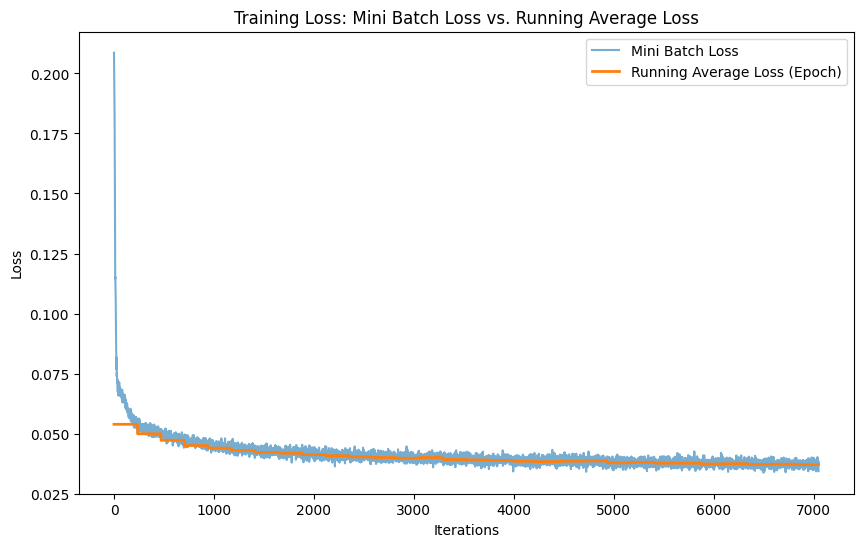

In [11]:
plot_training_logs(log_dict)

As we can see on the graph, there is a convergence during training. The loss curves over epochs follow the same trend as the mini-batch curves, even though the mini-batch ones vary slightly more, forming a zigzag pattern.

### Images visualisation

In [12]:
valid_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

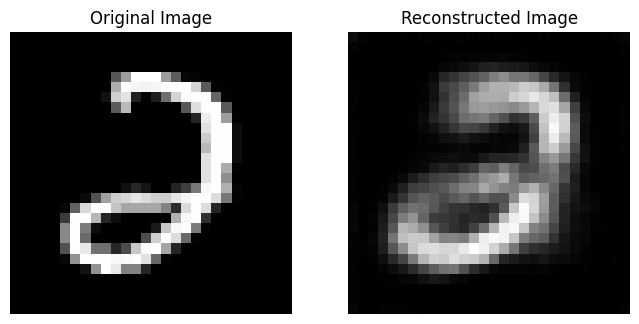

In [15]:
# Set the model to evaluation mode (disables dropout, batch norm, etc.)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = model.to(device)  # Move model to CPU
model.eval()

# Select a random index within the validation dataset
random_index = random.randint(0, len(valid_dataset) - 1)

# Load the image
original_image, _ = valid_dataset[random_index]

# Add a batch dimension and move the image to the same device as the model
original_image = original_image.unsqueeze(0).to(device)

# Disable gradients for inference
with torch.no_grad():
    reconstructed_image = model(original_image)

# Move images to CPU and remove the batch dimension for display
original_image = original_image.cpu().squeeze()
reconstructed_image = reconstructed_image.cpu().squeeze()

# Display the original and reconstructed images
plt.figure(figsize=(8, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap="gray")
plt.title("Reconstructed Image")
plt.axis("off")

plt.show()

Now, let's comment on the model's output. As shown above, we input an image of a 6. The model was able to reconstruct a new image from this input, and we can see that the 6 is fairly recognizable. While the reconstruction isn’t perfect, it’s clear enough for us to distinctly observe a 6.

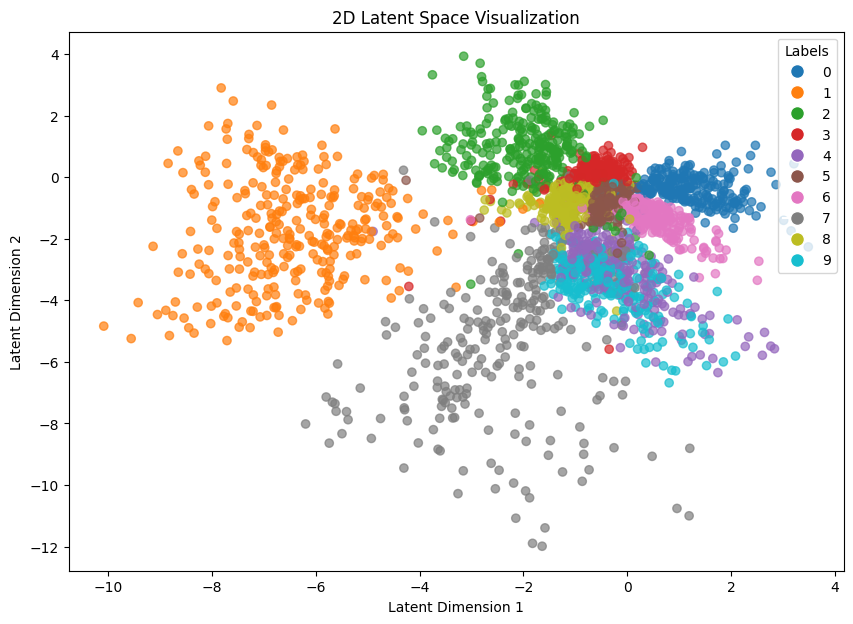

In [52]:
# Function to plot the 2D latent space
def plot_latent_space(autoencoder, data_loader, device, num_batches=2):
    autoencoder.eval()  # Set model to evaluation mode
    latents = []
    labels = []

    with torch.no_grad():  # Disable gradient computation
        for i, (data, label) in enumerate(data_loader):
            data = data.to(device) # Ensure data is on same device as model
            if i >= num_batches:  # Limit number of batches for visualization
                break
            latent = autoencoder.encoder(data)  # Pass data through encoder
            latents.append(latent)
            labels.append(label)

    # Concatenate results for all selected batches
    latents = torch.cat(latents).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    # Create scatter plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.7)
    
    # Create a legend with circle markers for each label using Line2D
    unique_labels = np.unique(labels)
    legend_patches = [Line2D([0], [0], marker='o', color='w', label=str(i),
                              markerfacecolor=plt.cm.tab10(i), markersize=10) for i in unique_labels]
    plt.legend(handles=legend_patches, title="Labels", loc="upper right")

    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("2D Latent Space Visualization")
    plt.show()

    return latents, labels

# Call the function with your model and DataLoader
latents, labels = plot_latent_space(model, train_loader, device, num_batches = 10)

Now, let’s analyze the latent space graph. Most classes have their own distinct zones. For example, class 1, which is shown in orange, has a clearly separated region, as does class 7 in gray. We also notice that class 2 (in green) and class 6 (in pink) occupy their own areas. Interestingly, class 4 (in purple) and class 9 (in light blue) are not entirely mixed but do show some overlap. Overall, the training results are satisfactory, as we can clearly distinguish the different classes.

### Generate a "new" image.

Now, we generate a new image by taking a random sample of n latent vectors from a specific class and averaging them. This approach should produces a 'representative' image of the class with slight variations. 

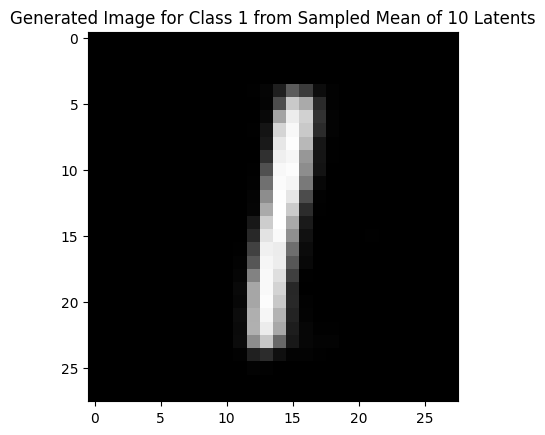

In [67]:
def generate_image_from_class_latent_sample_mean(autoencoder, latents, labels, target_class, device, n=10):
    """ Generates an image using the mean of a random sample of n latent vectors for a target class. """

    # Filter latent vectors for the target class
    class_latents = latents[labels == target_class]
    
    # Check that there are enough latent vectors for this class
    if class_latents.shape[0] == 0:
        print(f"No latent vectors found for class {target_class}.")
        return None
    elif class_latents.shape[0] < n:
        print(f"Not enough latent vectors for class {target_class}; using {class_latents.shape[0]} vectors instead of {n}.")
        n = class_latents.shape[0]  # Adjust n if there are fewer than n vectors available

    # Randomly sample n latent vectors from the class latents
    sampled_latents = class_latents[np.random.choice(class_latents.shape[0], n, replace=False)]

    # Calculate the mean vector for the sampled latents
    latent_mean = np.mean(sampled_latents, axis=0)  # Mean of sampled vectors
    latent_mean_tensor = torch.tensor(latent_mean).unsqueeze(0).to(device)  # Convert to PyTorch tensor and move the right device

    # Pass the mean vector to the decoder to generate an image
    autoencoder.eval()  # Set to evaluation mode
    with torch.no_grad():
        generated_image = autoencoder.decoder(latent_mean_tensor)

    # Display the generated image
    plt.imshow(generated_image.squeeze().cpu().numpy(), cmap="gray")
    plt.title(f"Generated Image for Class {target_class} from Sampled Mean of {n} Latents")
    plt.show()

# Call the function to generate an image for the class "1", using a sample of 10 latents
generate_image_from_class_latent_sample_mean(model, latents, labels, target_class=1, device=device, n=10)